In [1]:
import pandas as pd
import numpy as np
import torch

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


C:\Users\NITESH\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load test data
test_df = pd.read_csv("../data/test.csv")

# Load tokenizer & model
tokenizer = DistilBertTokenizerFast.from_pretrained("../model/saved_model")
model = DistilBertForSequenceClassification.from_pretrained("../model/saved_model")

model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [5]:
def predict_batchwise(texts, batch_size=8):
    all_preds = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = model(**inputs)

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

    return np.array(all_preds)


In [6]:
y_true = test_df["label"].values
y_pred = predict_batchwise(test_df["text"].tolist(), batch_size=8)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))


              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4695
        Real       1.00      1.00      1.00      4283

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



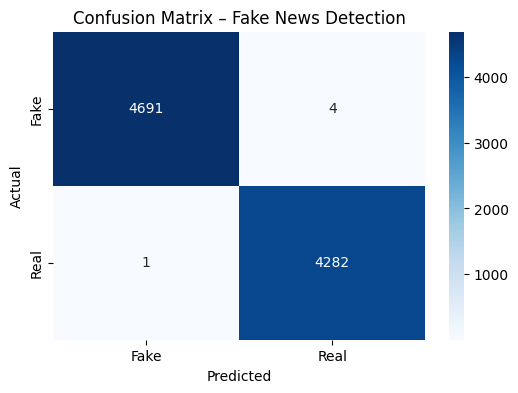

In [8]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Fake News Detection")
plt.show()


In [9]:
samples = [
    "Government announces new education policy",
    "Aliens have landed in New York city yesterday"
]

preds = predict(samples)

for text, p in zip(samples, preds):
    print(text)
    print("Prediction:", "REAL" if p == 1 else "FAKE")
    print("-" * 50)


Government announces new education policy
Prediction: FAKE
--------------------------------------------------
Aliens have landed in New York city yesterday
Prediction: FAKE
--------------------------------------------------
